# Parse the Dataset
Read data, store it in 

In [1]:
%matplotlib inline
import sys
from glob import glob
sys.path = glob('/projects/CSC249ADCD01/packages/*') + sys.path
from ase.io import qbox, cube
from ase.visualize import view
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from stopping_power_ml.io import load_directory, get_charge_density_interpolator
import pandas as pd
import numpy as np
import os

## Read in an Output File
Read in one of the files from the `v = 1.0` calculation.

In [2]:
%%time
data = qbox.read_qbox(os.path.join('datasets', '256_Al', 'Dv1.0', 'kpgenlong_sd_psd_combo_r17_111_cutoff_50_1.out'))

Wall time: 31.2 s


The output file is a large Al lattice, as expected.

The following figure shows the atomic structure for the first timestep of the simulation. The red particle is the proton projectile.

In [3]:
view_data = data.copy()
view_data[-1].set('symbol', 'O')
view(view_data, viewer='x3d')

## Read the Electron Density File
The `Al_semi_core_gs.cube` contains the electron density for Aluminum in its ground state before introducing the particle, as computed using Density Functional Theory. We plan to use this data as input into the machine learning model.

In [4]:
%%time
density, cube_atoms = get_charge_density_interpolator(os.path.join('datasets', '256_Al', 'Al_semi_core_gs.cube'))

Wall time: 6.38 s


One issue with the charge density data is that it does not exactly obey the symemtries of the lattice. To remedy this, we create an interpolator that enforces this symmetry. 

In [5]:
%%time
sym_density, cube_atoms = get_charge_density_interpolator(os.path.join('datasets', '256_Al', 'Al_semi_core_gs.cube'),
                                                          symmetry=True, sym_accuracy=16)

Wall time: 2min 6s


### Make Sure the Interpolator has the Correct Symmetry
The charge density should have the same symmetry as the lattice. In this part, we make sure that is the case.

In [6]:
def make_density_plot(ax, center, vec1, vec2, density, dist=0.2, offset=[0,0,0]):
    # Compute the normal vectors
    vec1 = np.array(vec1) / np.linalg.norm(vec1)
    vec2 = np.array(vec2) / np.linalg.norm(vec2)
    
    # Make the grid
    spacings = np.linspace(-dist, dist, 128)
    xs, ys = np.meshgrid(spacings, spacings)
    points = np.array([i * vec1 + j * vec2 + center for i,j in zip(xs.flatten(), ys.flatten())])
    points = points % 1
    
    # Make the plots
    chg_density = density(np.add(points, offset)).reshape(xs.shape)
    pct = ax.pcolor(xs, ys, chg_density, vmin=0, vmax=3, cmap='Blues')
    
    ax.set_xticks([])
    ax.set_yticks([])
    return chg_density

Make sure the symmetrized output is the same as the unsymmetrized

Maximum difference: 0.222345496261


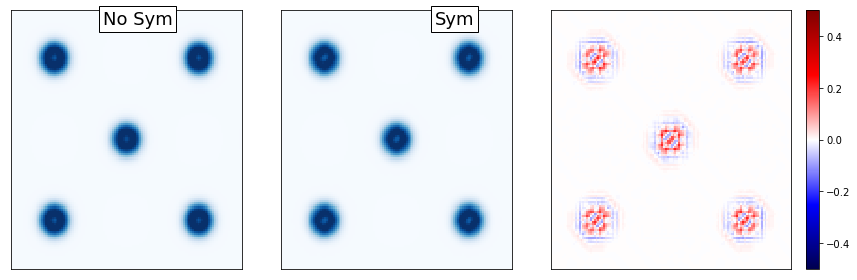

In [7]:
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1,1,1.3]})

fig.text(1.0/6, 0.9, 'No Sym', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})
fig.text(0.5, 0.9, 'Sym', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})

# Plot the unsymmetrized and its density difference
density_nosym = make_density_plot(ax[0], [0,0,0], [0,0,1], [0,1,0], density)
density_sym = make_density_plot(ax[1], [0,0,0], [0,0,1], [0,1,0], sym_density)
print('Maximum difference:', np.abs(density_nosym-density_sym).max())
d = ax[2].pcolor(density_nosym-density_sym, vmin=-0.5, vmax=0.5, cmap='seismic')
fig.colorbar(d)
ax[2].set_xticks([])
ax[2].set_yticks([])

fig.tight_layout()
fig.set_size_inches(12 * 1.1, 4)

*Finding*: The differences are small and are largest around the nucleus.

Plot the $xz$-plane centered around [0,0,0], plot the difference between the charge density on the $yz$ plane centered at a different point in the lattice

Maximum difference: 6.26165785889e-14


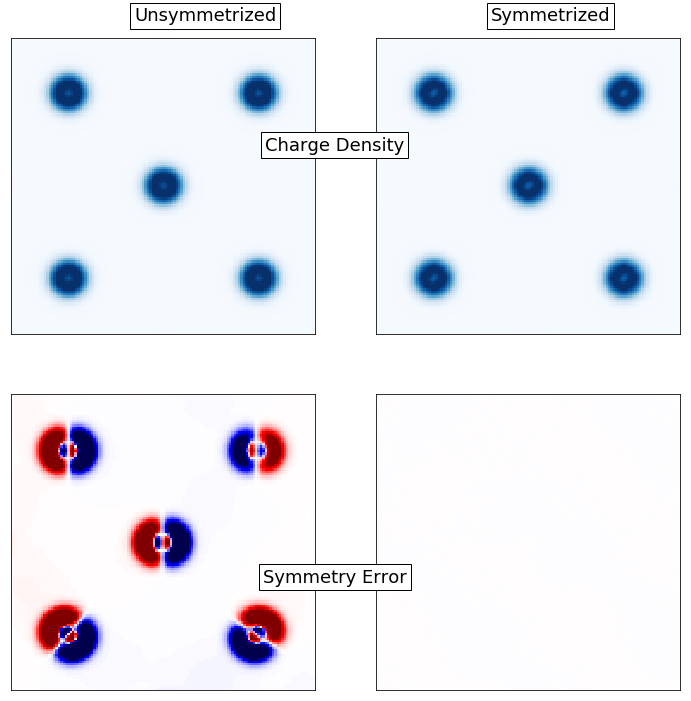

In [8]:
fig, ax = plt.subplots(2, 2)

fig.text(0.5, 0.75, 'Charge Density', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})
fig.text(0.5, 0.25, 'Symmetry Error', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})

# Plot the unsymmetrized and its density difference
density_shifted = make_density_plot(ax[0,0], [0,0,0], [0,0,1], [1,0,0], density)
density_zero = make_density_plot(ax[0,0], [0.25,0,0.75], [0,0,1], [0,1,0], density)
d = ax[1,0].pcolor(density_shifted-density_zero, vmin=-1e-4, vmax=1e-4, cmap='seismic')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.text(0.35, 0.9, 'Unsymmetrized', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})

# Plot the symmetrized and its density difference

density_shifted = make_density_plot(ax[0,1], [0,0,0], [0,0,1], [1,0,0], sym_density)
density_zero = make_density_plot(ax[0,1], [0.25,0,0.75], [0,0,1], [0,1,0], sym_density)
print('Maximum difference:', np.abs(density_shifted-density_zero).max())
d = ax[1,1].pcolor(density_shifted-density_zero, vmin=-1e-4, vmax=1e-4, cmap='seismic')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.text(0.75, 0.9, 'Symmetrized', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})

fig.set_size_inches(12, 12)

*Finding*: This upper row of the plot shows the charge density along the $xy$-plane of the simulation cell, which shows the expected pattern for [100] of the FCC structure. The bottom row shows the difference between this density, and the density computed on an equivalent plane in the structure, which illustrates the broken symmetries for the 'unsymmetrized' interpolation scheme.

## Load in Dataset
We need to read in several things from each file:

1. The energy of the system
1. The atomic structure in that frame
1. The location, velocity, and force acting on the particle

Find all the directories containing QBOX data

In [9]:
dirs = set([os.path.dirname(x) for x in glob("**/kpg*out", recursive=True)])

In [10]:
data = []
for file in tqdm(dirs, desc='Directory'):
    frame = load_directory(file, prefix="kpg*")
    frame['file'] = file
    data.append(frame)
data = pd.concat(data)
print('Read in %d training points'%len(data))

A Jupyter Widget


Read in 50069 training points


In [11]:
data.head()

,atoms,energy,file_id,force,frame_id,position,velocity,file,timestep,displacement,directory
timestep,,,,,,,,,,,
0,"(Atom('Al', [11.483931950000001, 11.4839319500...",-18651.709649,1,-0.000129,0,"[0.0, 5.74196597, 5.74196597]","[0.232382, 0.650984, 0.722647]",datasets\256_Al\Dv1.0,0,0.000000,datasets\256_Al\Dv1.0
1,"(Atom('Al', [11.483931950000001, 11.4839319500...",-18651.701982,1,0.028183,1,"[0.00331934, 5.75126463, 5.75228826]","[0.232382, 0.650984, 0.722647]",datasets\256_Al\Dv1.0,1,0.014284,datasets\256_Al\Dv1.0
2,"(Atom('Al', [11.483931950000001, 11.4839319500...",-18651.701392,1,0.054346,2,"[0.00663869, 5.76056328, 5.76261055]","[0.232382, 0.650984, 0.722647]",datasets\256_Al\Dv1.0,2,0.028568,datasets\256_Al\Dv1.0
3,"(Atom('Al', [11.483931950000001, 11.4839319500...",-18651.700428,1,0.080006,3,"[0.00995803, 5.76986194, 5.77293284]","[0.232382, 0.650984, 0.722647]",datasets\256_Al\Dv1.0,3,0.042852,datasets\256_Al\Dv1.0
4,"(Atom('Al', [11.483931950000001, 11.4839319500...",-18651.699098,1,0.104996,4,"[0.01327738, 5.77916059, 5.78325513]","[0.232382, 0.650984, 0.722647]",datasets\256_Al\Dv1.0,4,0.057136,datasets\256_Al\Dv1.0


### Save the Data as a Pickle
For use in later scripts

In [12]:
data.to_pickle('data.pkl')